In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import seaborn as sns
import inspect

import torch
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import timm
import torchvision

from keras.utils import  to_categorical

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

c:\Users\Stanislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

# Валидация (необходимые функции в блоке обучения)

In [7]:
name = 'full_tune_67.80000000000001_73.28956007879187.pth'
model = torch.load(f'./caformer_b36.sail_in22k_ft_in1k_384/{name}')
model = model.to(device)

In [8]:
model.eval()
val_loss = 0
val_correct = 0
preds = torch.tensor([]).to(device)
y_ = torch.tensor([]).to(device)
correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        X, y = images.to(device), labels.to(device)
        pred = model(X)
        preds = torch.cat((preds, pred.argmax(dim=1)))
        y_ = torch.cat((y_, y.argmax(dim=1)))
        correct += get_num_correct(y, pred)
preds = preds.cpu().numpy()
y_ = y_.cpu().numpy()

100%|██████████| 16/16 [00:34<00:00,  2.17s/it]


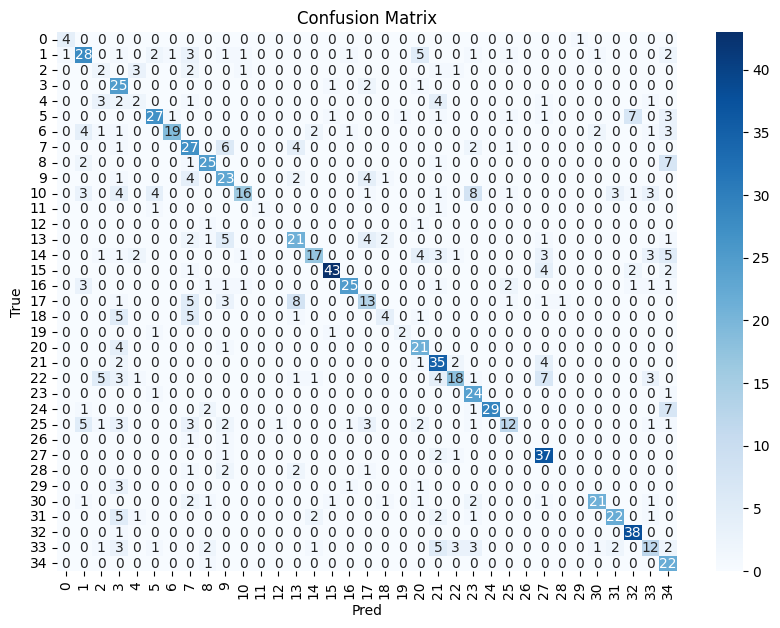

0.615


In [14]:
CM = confusion_matrix(y_, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(accuracy_score(y_, preds))

# Обучение

In [2]:
label_id = pd.DataFrame(data=pd.read_csv('label_to_id.csv', delimiter='\t'))
df = pd.DataFrame(data=pd.read_csv('train.csv', delimiter='\t'))
df = df.sample(frac=1, random_state=12312)

In [3]:
df_train, df_test = df[1000:], df[:1000]

In [4]:
def get_num_correct(preds, labels):
        return preds.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [5]:
def load_data(df_train_id, size=256, d_type = np.float32, batch_size = 8, augmentation=False, aug_coef = 2, trans=False):
    if augmentation:
        if trans == False:
            trans = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(p=1),
            torchvision.transforms.RandomVerticalFlip(p=1),
            torchvision.transforms.RandomRotation(90),
            torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 0.5)),
            torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
            ])
        n_help = df_train_id.shape[0]
        n_sample = df_train_id.shape[0] * aug_coef
        label = np.tile((to_categorical(df_train_id['label_id'].to_numpy(), num_classes=35)), (aug_coef, 1))
        df_train = np.zeros((n_sample, 3, size, size), dtype=d_type)
        for index in tqdm(range(int(n_sample / aug_coef))):
            name = df_train_id.iloc[index, 0]
            path = f'train/train/{name}'
            image = Image.open(path).resize((size, size)).convert('RGB')
            df_train[index] = (np.array(image, dtype=d_type) / 255).reshape((-1, 3, size, size))
            for i in range(1, aug_coef):
                image = trans(image)
                df_train[index + n_help * i] = (np.array(image, dtype=d_type) / 255).reshape((-1, 3, size, size))
    else:
        n_sample = df_train_id.shape[0]
        label = to_categorical(df_train_id['label_id'].to_numpy(), num_classes=35)
        df_train = np.zeros((n_sample, 3, size, size), dtype=d_type)
        for index in tqdm(range(n_sample)):
            name = df_train_id.iloc[index, 0]
            path = f'train/train/{name}'
            image = Image.open(path).resize((size, size)).convert('RGB')
            df_train[index] = (np.array(image, dtype=d_type) / 255).reshape((-1, 3, size, size))
            
    df_train = TensorDataset(torch.from_numpy(df_train).type(torch.FloatTensor), torch.from_numpy(label).type(torch.FloatTensor))
    del label
    df_train = DataLoader(df_train, batch_size=batch_size, pin_memory=True, shuffle=True)

    return df_train

In [6]:
image_size = 380
train_loader = load_data(df_train, image_size, np.float32, batch_size=64, augmentation=True, aug_coef=3)
test_loader = load_data(df_test, image_size, np.float32, batch_size=64)

100%|██████████| 1000/1000 [00:13<00:00, 72.88it/s]


In [8]:
name_model = 'tf_efficientnet_b4.ns_jft_in1k'
model = timm.create_model(f'{name_model}', pretrained=True, num_classes=35)
# model.classifier = torch.nn.Sequential(
#   torch.nn.Hardswish(),
#   torch.nn.Dropout(p=0.25, inplace=True),
#   torch.nn.Linear(in_features=1792, out_features=35, bias=True)
# )
# model.load_state_dict(torch.load(f'./{name_model}/tune_36.8_last_layer_fn'))

In [10]:
model.grad_checkpointing = True
model = model.to(device)

In [14]:
sum(param.numel() for param in model.parameters())

17611371

In [15]:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.blocks[5][13:].parameters():
#     param.requires_grad = True
# for param in model.conv_head.parameters():
#     param.requires_grad = True
# for param in model.bn2.parameters():
#     param.requires_grad = True
# for param in model.classifier.parameters():
#     param.requires_grad = True

In [16]:
best_acc = 0

In [17]:
n_sample_train = df_train.shape[0]
n_sample_test = df_test.shape[0]
epochs = 10
learning_rate = 0.00003

# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):

    n_sample = 0

    print("Epoch: ", epoch+1)
    epoch_loss = 0
    epoch_correct = 0
    model.train()

    for images, labels in tqdm(train_loader):
        X, y = images.to(device), labels.to(device)
        y_ = model(X)

        loss = F.cross_entropy(y_, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # if n_sample % 64 == 0:
        #     optimizer.step()
        #     optimizer.zero_grad()
        
        epoch_loss += loss.item()
        epoch_correct += get_num_correct(y_, y)

        n_sample += 4

    accuracy_train = epoch_correct/len(train_loader.dataset)*100
    print("Train Loss: ", epoch_loss)
    print("Train Acc: ", accuracy_train)
    
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            X, y = images.to(device), labels.to(device)
            preds = model(X)
            loss = F.cross_entropy(preds, y)
            val_loss += loss.item()
            val_correct += get_num_correct(preds, y)
    accuracy_val = val_correct/n_sample_test*100
    print("Val Loss: ", val_loss)
    print("Val Acc: ", accuracy_val)
    if accuracy_val > best_acc:
        best_acc = accuracy_val
        torch.save(model, f'./{name_model}/full_tune_{accuracy_val}_{accuracy_train}.pth')

Epoch:  1


  0%|          | 0/357 [00:00<?, ?it/s]c:\Users\Stanislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
100%|██████████| 357/357 [11:27<00:00,  1.93s/it]


Train Loss:  1047.3234848976135
Train Acc:  19.5578901291311


  0%|          | 0/16 [00:00<?, ?it/s]c:\Users\Stanislav\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


Val Loss:  37.9493772983551
Val Acc:  29.4
Epoch:  2


100%|██████████| 357/357 [11:27<00:00,  1.92s/it]


Train Loss:  752.9988139867783
Train Acc:  38.71744364193478


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Val Loss:  31.967204570770264
Val Acc:  40.300000000000004
Epoch:  3


100%|██████████| 357/357 [11:25<00:00,  1.92s/it]


Train Loss:  594.8941061496735
Train Acc:  51.11402932808055


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


Val Loss:  29.67101514339447
Val Acc:  45.1
Epoch:  4


100%|██████████| 357/357 [11:24<00:00,  1.92s/it]


Train Loss:  462.0936089158058
Train Acc:  62.58262201794703


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


Val Loss:  28.60714876651764
Val Acc:  46.6
Epoch:  5


100%|██████████| 357/357 [11:23<00:00,  1.92s/it]


Train Loss:  342.6812930703163
Train Acc:  73.42963449332458


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


Val Loss:  28.782557487487793
Val Acc:  48.199999999999996
Epoch:  6


 40%|███▉      | 142/357 [04:31<06:50,  1.91s/it]


KeyboardInterrupt: 